# An intro to quantum machine learning 🚀
(with one qubit!)

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


Since we will only use one qubit, we need to reduce the dimensionality of the data. For this, we will use Kernel PCA.

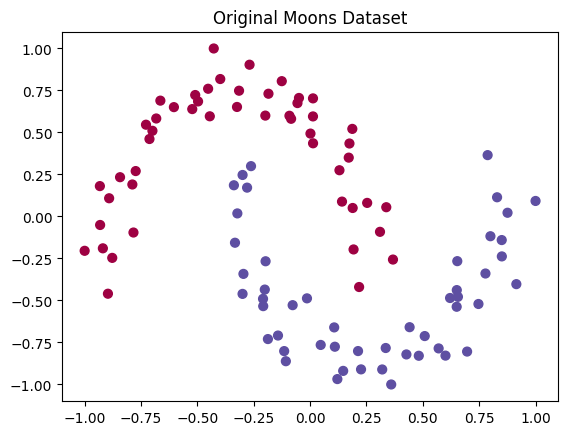

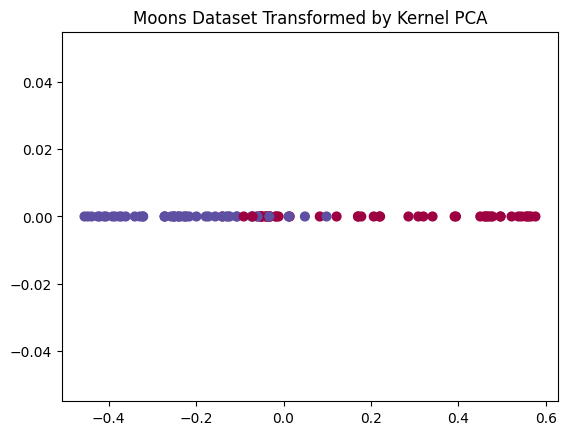

In [98]:
n_samples = 100

# Create the dataset
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

# Preprocess the dataset
scaler = MinMaxScaler((-1, 1))
X = scaler.fit_transform(X)

# Apply Kernel PCA
kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

# Plot the original dataset
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Original Moons Dataset")

# Plot the transformed dataset
plt.figure()
plt.scatter(X_kpca, np.zeros_like(X_kpca), c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Moons Dataset Transformed by Kernel PCA")

plt.show()


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

## Variational Quantum Classifier

In [100]:
from qiskit_machine_learning.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap

from qiskit.circuit import ParameterVector, Parameter, QuantumCircuit

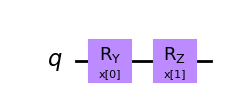

In [101]:
def build_layered_model_circuit(n_layers = 1):
    """Credits to Maxime Dion"""

    data_params = ParameterVector('x', 2)
    weights_params = ParameterVector('w', 2*n_layers)

    model_circuit = QuantumCircuit(1)
    model_circuit.ry(data_params[0],0)
    model_circuit.rz(data_params[1],0)

    # for l in range(1,n_layers):
    #     model_circuit.ry(weights_params[2*l+0] * data_params[0] + rotation_params[2*l+0],0)
    #     model_circuit.rz(weights_params[2*l+1] * data_params[1] + rotation_params[2*l+1],0)
    # model_circuit.ry(rotation_params[0],0)
    
    return model_circuit

build_layered_model_circuit().draw('mpl')

In [102]:
num_qubits = 1
feature_map = build_layered_model_circuit()#ZFeatureMap(feature_dimension=1, reps=1)
print(feature_map.decompose())

global phase: -0.5*x[1]
   ┌─────────────┐┌──────────┐
q: ┤ R(x[0],π/2) ├┤ U1(x[1]) ├
   └─────────────┘└──────────┘


In [103]:
var_form = TwoLocal(num_qubits, ['rz', 'ry'], 'cz', reps=3, insert_barriers=True)
print(var_form.decompose())

   ┌──────────┐┌──────────┐ ░  ░ ┌──────────┐┌──────────┐ ░  ░ ┌──────────┐»
q: ┤ Rz(θ[0]) ├┤ Ry(θ[1]) ├─░──░─┤ Rz(θ[2]) ├┤ Ry(θ[3]) ├─░──░─┤ Rz(θ[4]) ├»
   └──────────┘└──────────┘ ░  ░ └──────────┘└──────────┘ ░  ░ └──────────┘»
«   ┌──────────┐ ░  ░ ┌──────────┐┌──────────┐
«q: ┤ Ry(θ[5]) ├─░──░─┤ Rz(θ[6]) ├┤ Ry(θ[7]) ├
«   └──────────┘ ░  ░ └──────────┘└──────────┘


In [104]:
optimizer = SPSA(maxiter=40)
vqc = VQC(num_qubits, 
        feature_map, 
        ansatz = var_form, 
        loss = 'cross_entropy',
        optimizer = optimizer, 
)

In [105]:
vqc.fit(X_train, y_train)

/Users/jonas/anaconda3/envs/QMLWorkshop/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
test_accuracy = vqc.score(X_test, y_test)
print(f'Testing success ratio: {test_accuracy}')

## Quantum Support Vector Machine

In [109]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from utils import plot_kernel_matrix

In [110]:
# Initialize the quantum kernel and QSVM
data_encoding_circuit = build_layered_model_circuit()
kernel = FidelityQuantumKernel(feature_map=data_encoding_circuit)
qsvc = QSVC(quantum_kernel=kernel)

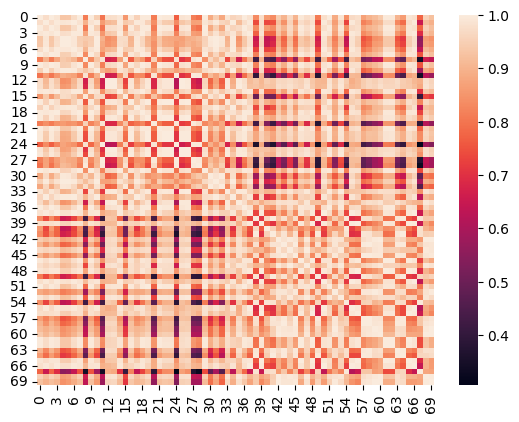

In [111]:
plot_kernel_matrix(X_train, y_train, data_encoding_circuit)

In [112]:
# fit the model
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7ff4bccc1f40>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [113]:
test_accuracy = qsvc.score(X_test, y_test)
print(f'Testing success ratio: {test_accuracy}')

Testing success ratio: 0.6333333333333333
